# Check track efficiency

This should be higher than PFO track efficiency! 

In [1]:
save_status = False

In [2]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['tree;1']
    data = tree.arrays(library="np", entry_start=0, entry_stop=500000)
    return data

In [4]:
path= "/eos/experiment/fcc/ee/datasets/CLD_fullsim_tagging_trackPFOcheck/hadded_fakerate"
dic = {
    "bb": np.array([]),
    "gg": np.array([]),
    "tautau": np.array([])
}

for process in dic.keys():
    data = load_data(f"{path}/H{process}.root")
    dic[process] = data

In [5]:
dic["bb"].keys()

dict_keys(['recojet_isG', 'recojet_isU', 'recojet_isD', 'recojet_isS', 'recojet_isC', 'recojet_isB', 'recojet_isTAU', 'mcpid', 'mc_pfo_type', 'recopid', 'momentum', 'theta', 'energy', 'mc_track_found', 'pfo_recopid', 'pfo_momentum', 'pfo_theta', 'pfo_energy', 'pfo_MCpid', 'pfo_track'])

Okay let's check the variable `mc_track_found` to check the track efficiency!

In [6]:
def normalize_hist(data, ref_counts, bins, range):
    counts, _ = np.histogram(data, bins=bins, range=range, density=False)
    # Avoid division by zero by using np.where
    normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)
    return normalized_counts

In [7]:
def ind_x_type(Htype, x):
    if x=="e":
        ind_x = np.where(abs(np.concatenate(dic[Htype]["mcpid"])) == 11)
    elif x=="muon":
        ind_x = np.where(abs(np.concatenate(dic[Htype]["mcpid"])) == 13)
    elif x=="chad":
        ind_x = np.where(abs(np.concatenate(dic[Htype]["mcpid"])) == 211)
    return ind_x

In [8]:
def eff(Htype, ind_ptype):
    ind_track_found = np.where(np.concatenate(dic[Htype]["mc_track_found"])[ind_ptype] == 1)
    len_all = len(np.concatenate(dic[Htype]["mc_track_found"])[ind_ptype])
    return np.round(len(ind_track_found[0])/len_all*100, 2)

In [9]:
def track_eff(Htype, save=False):
    ranges = [[0, 50], [0, 3.14]]
    xlabels = [r"$p$ [GeV]", r"$\theta$ [rad]"]
    num_bins = 60

    fig, ax = plt.subplots(2, 3, figsize=(17,8))
    ind_track_found = np.where(np.concatenate(dic[Htype]["mc_track_found"]) == 1)
    total_eff = np.round(len(ind_track_found[0])/len(np.concatenate(dic[Htype]["mc_track_found"]))*100, 2)
    fig.suptitle(f"H{Htype} track efficiency ({total_eff} %)")
    for j, ptype in enumerate(["e", "muon", "chad"]):
        for i, obs in enumerate(["momentum", "theta"]):
            #if Htype=="gg" and (l=="e" or l=="muon"):
            #    ranges[0] = [0, 15]
            # Logarithmic binning for "momentum"
            if obs == "momentum":
                bins = np.logspace(np.log10(ranges[i][0]+1e-1), np.log10(ranges[i][1]), num_bins)
                ax[i, j].set_xscale("log")
            else:
                bins = np.linspace(ranges[i][0], ranges[i][1], num_bins)
            # Calculate the reference histogram counts
            ind_ptype = ind_x_type(Htype, ptype)
            ref_counts, bin_edges = np.histogram(np.concatenate(dic[Htype][obs])[ind_ptype], bins=bins, range=ranges[i], density=False)

            # Normalize each histogram data
            i_pfo_track = np.where(np.concatenate(dic[Htype]["mc_track_found"]) == 1)
            ind_interest = np.intersect1d(ind_ptype, i_pfo_track)
            track_ptype_data = np.concatenate(dic[Htype][obs])[ind_interest]
            
            normalized_track = normalize_hist(track_ptype_data, ref_counts, bins, range=ranges[i])

            # Plot normalized histograms
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting
            effi = eff(Htype, ind_ptype)
            ax[i, j].plot(bin_centers, normalized_track, drawstyle='steps-mid', linewidth=2.0, label=f"MC {ptype}, {effi} % eff") #, label=f"MC {l}, track ({effi[2]}%)")
            ax[i, j].grid()
            ax[i, j].legend()
            ax[i, j].set_xlabel(xlabels[i])
            ax[i, j].set_ylabel("efficiency")
            ax[i, j].set_ylim(0, 1.01)

    plt.tight_layout()
    if save:
        plt.savefig(f"./hist-trackPFOcheck/track_eff_{Htype}.pdf")
    plt.show()

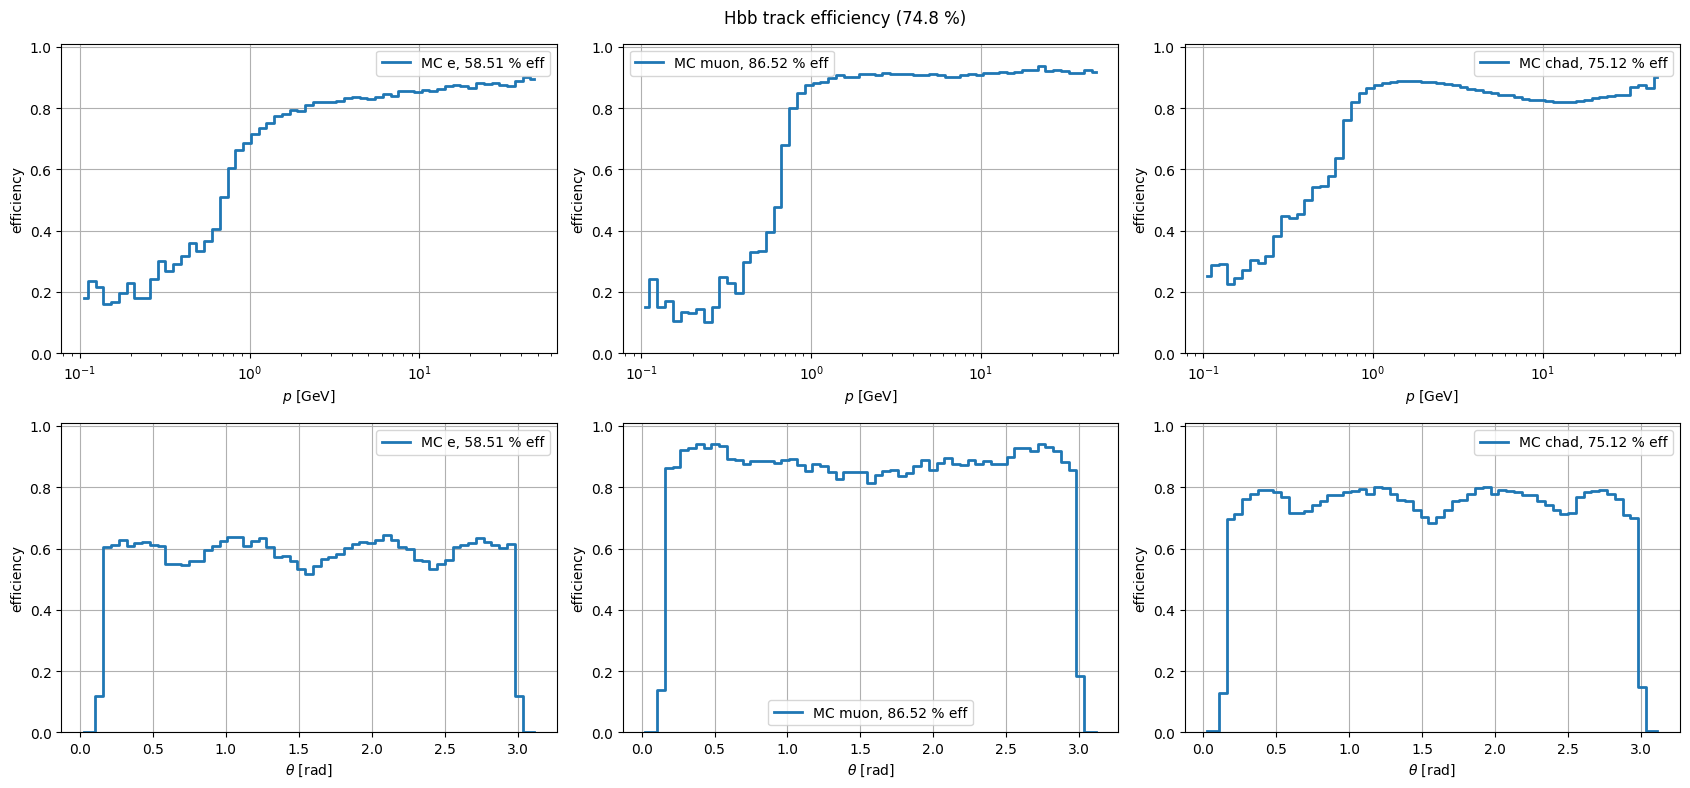

In [10]:
track_eff("bb", save=save_status)

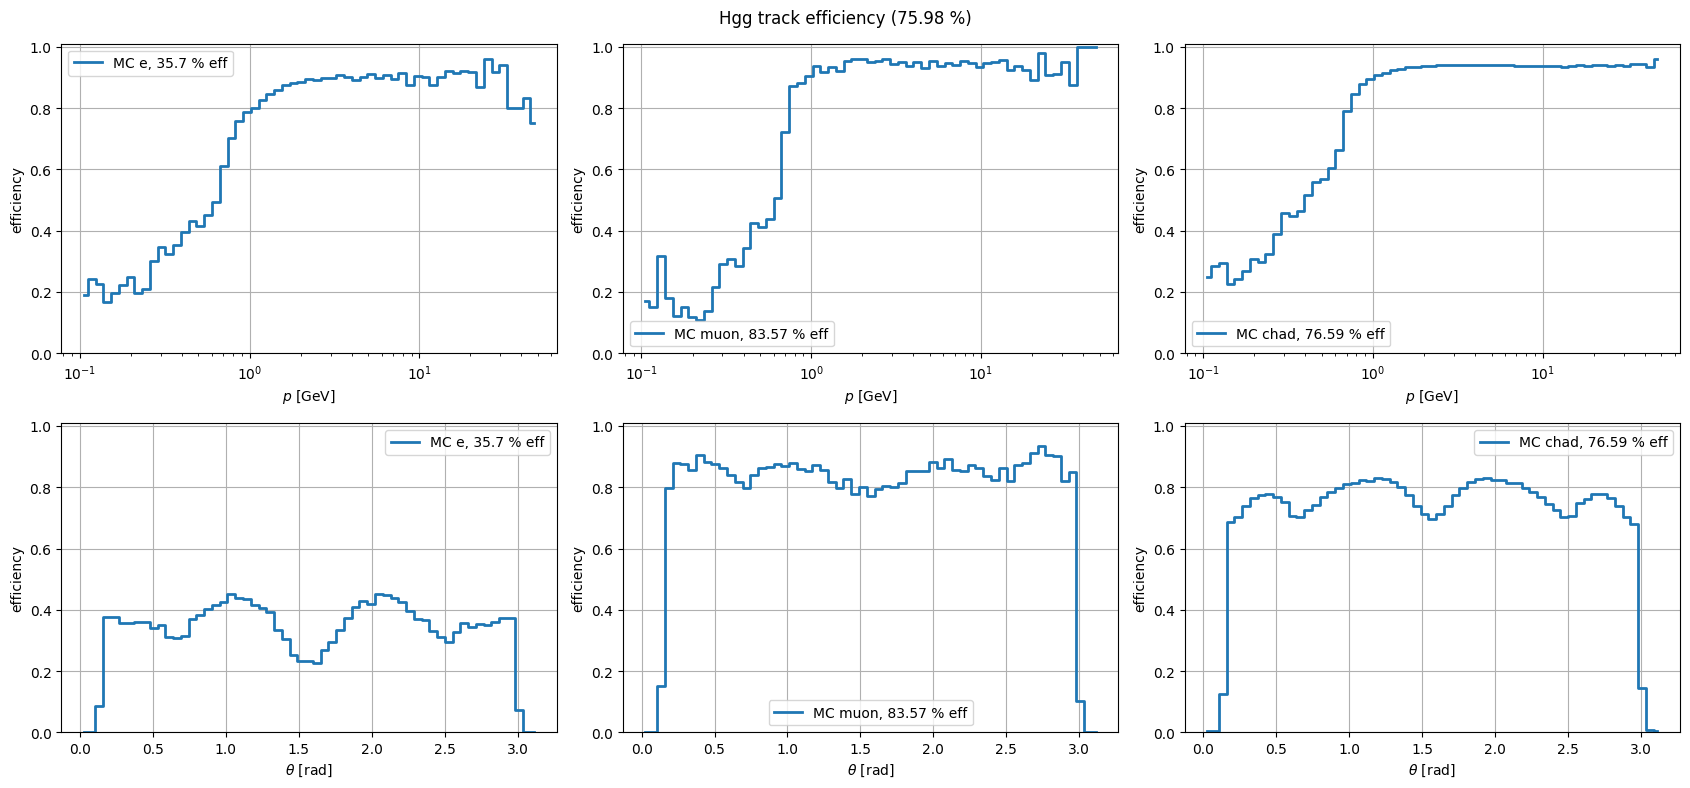

In [11]:
track_eff("gg", save=save_status)

/tmp/ipykernel_2554753/1752035420.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


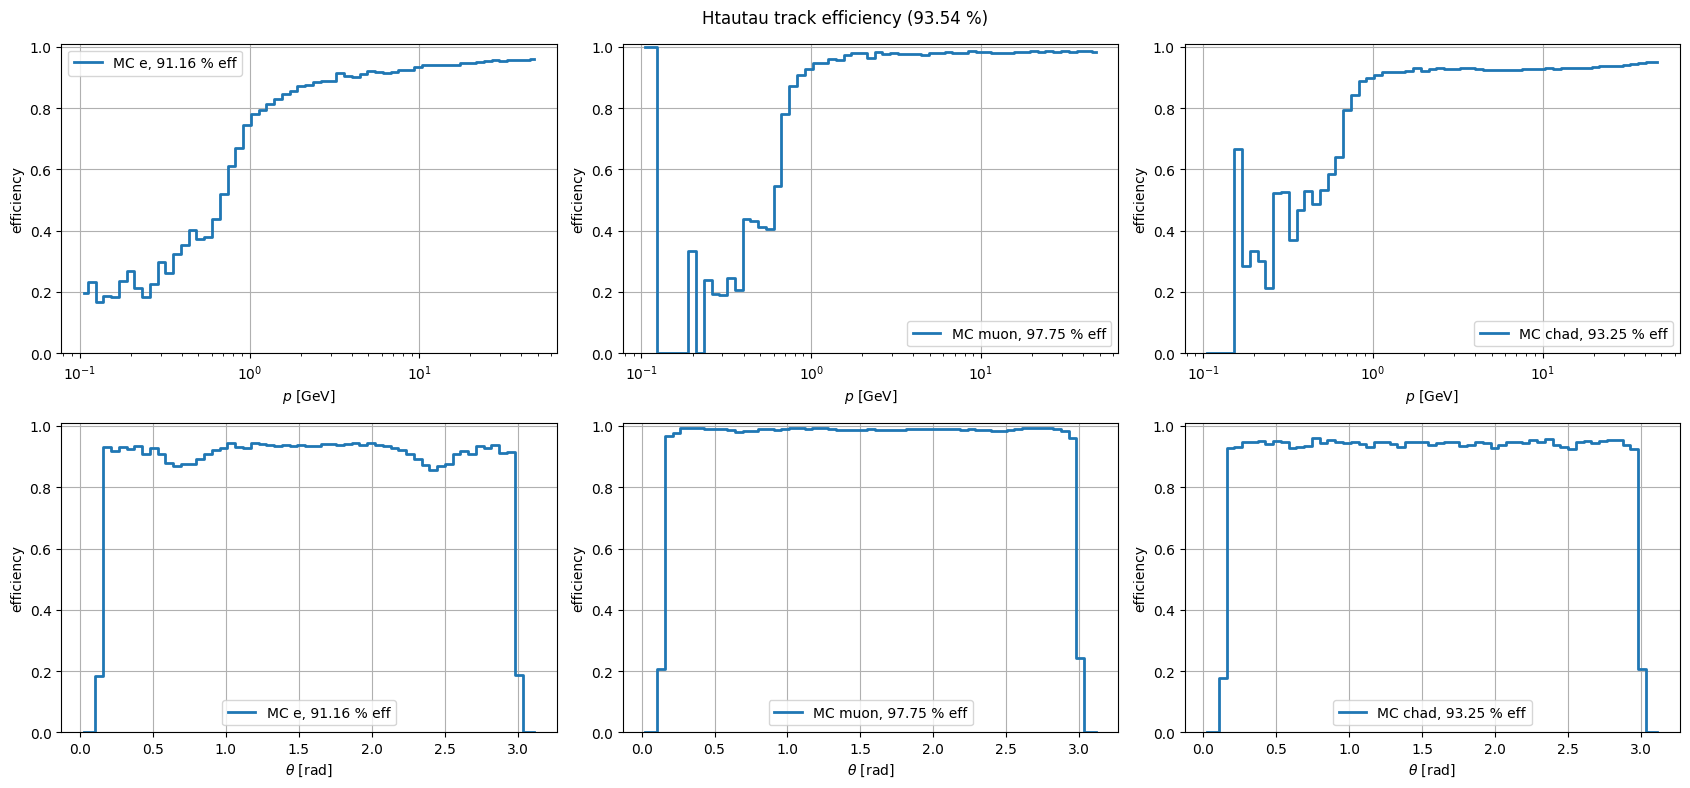

In [12]:
track_eff("tautau", save=save_status)

# Splitting this into 3 regions of momenta and 2 angles

In [13]:
from functools import reduce

In [14]:
def ind_p_cut(Htype, p_cut):
    data_p = np.concatenate(dic[Htype]["momentum"])
    if p_cut=="low":
        ind_p = np.where(data_p < 0.6)
    elif p_cut=="middle":
        ind_p = np.where((data_p >= 0.6) & (data_p <= 5))
    elif p_cut=="high":
        ind_p = np.where(data_p > 5)
    return ind_p

def ind_x_pfo_p(Htype, x, p_cut):
    ind_x = ind_x_type(Htype, x)
    ind_p = ind_p_cut(Htype, p_cut)

    ind_track_found = np.where(np.concatenate(dic[Htype]["mc_track_found"]) == 1)
    ind_x_pcut_track = reduce(np.intersect1d, (ind_track_found, ind_x, ind_p))

    return ind_x_pcut_track

def subplot_pfo_pcut(ax, Htype):
    ranges = [0, 3.14]
    bins=60
    obs="theta"
    p_cut_labels = [r"$p<0.6$ GeV", r"$0.6 < p < 5$ GeV", r"$p>5$ GeV"]
    for j, xtype in enumerate(["e", "muon", "chad"]):
        for i, p_cut in enumerate(["low", "middle", "high"]):
            ind_xtype = ind_x_type(Htype, xtype)
            ind_p = ind_p_cut(Htype, p_cut)
            ind_ref = reduce(np.intersect1d, (ind_xtype, ind_p))

            ref_counts, bin_edges = np.histogram(np.concatenate(dic[Htype][obs])[ind_ref], bins=bins, range=ranges, density=False)

            ind_interest = ind_x_pfo_p(Htype, xtype, p_cut)

            # Normalize each histogram data
            track_ptype_data = np.concatenate(dic[Htype][obs])[ind_interest]
            normalized_track = normalize_hist(track_ptype_data, ref_counts, bins, range=ranges)

            # Plot normalized histograms
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting
            effi = eff(Htype, ind_ref)
            ax[i, j].plot(bin_centers, normalized_track, drawstyle='steps-mid', linewidth=2.0, label=f"MC {xtype}, {effi} % eff") #, label=f"MC {l}, track ({effi[2]}%)")
            ax[i, j].grid()
            ax[i, j].legend()
            ax[i, j].set_xlabel(r"$\theta$ [rad]")
            ax[i, j].set_ylabel("efficiency")
            ax[i, j].set_ylim(0, 1.01)
            ax[i, j].set_title(p_cut_labels[i])

def plot_pfo_alltype_sliced_p(Htype="bb", save=False):
    """plot theta but for 3 different p cuts"""
    fig, ax = plt.subplots(3,3, figsize=(17,12))
    ind_track_found = np.where(np.concatenate(dic[Htype]["mc_track_found"]) == 1)
    total_eff = np.round(len(ind_track_found[0])/len(np.concatenate(dic[Htype]["mc_track_found"]))*100, 2)
    fig.suptitle(f"H{Htype} ({total_eff} % track eff.)")
    subplot_pfo_pcut(ax, Htype=Htype)

    plt.tight_layout()
    if save:
        plt.savefig(f"./hist-trackPFOcheck-trackeff/H{Htype}_trackeff_sliced_p.pdf")
    plt.show()

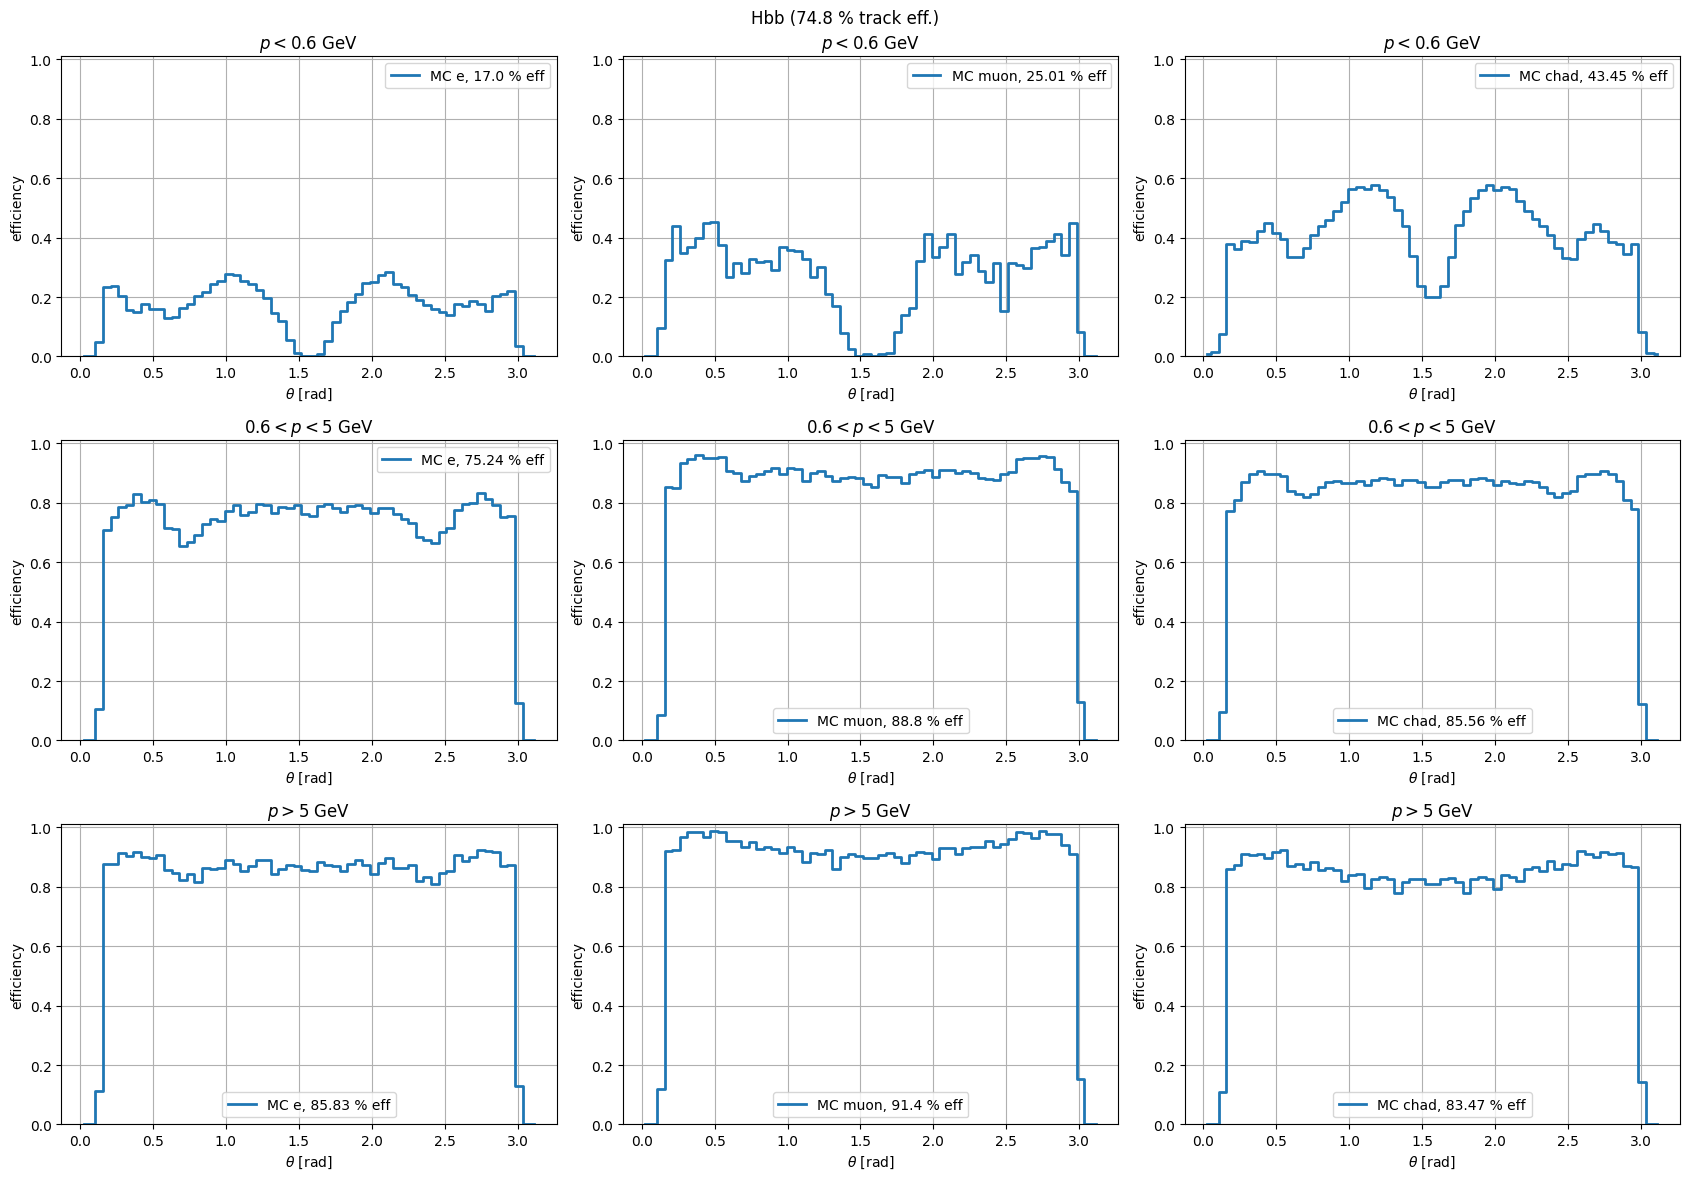

In [15]:
plot_pfo_alltype_sliced_p(save=save_status)

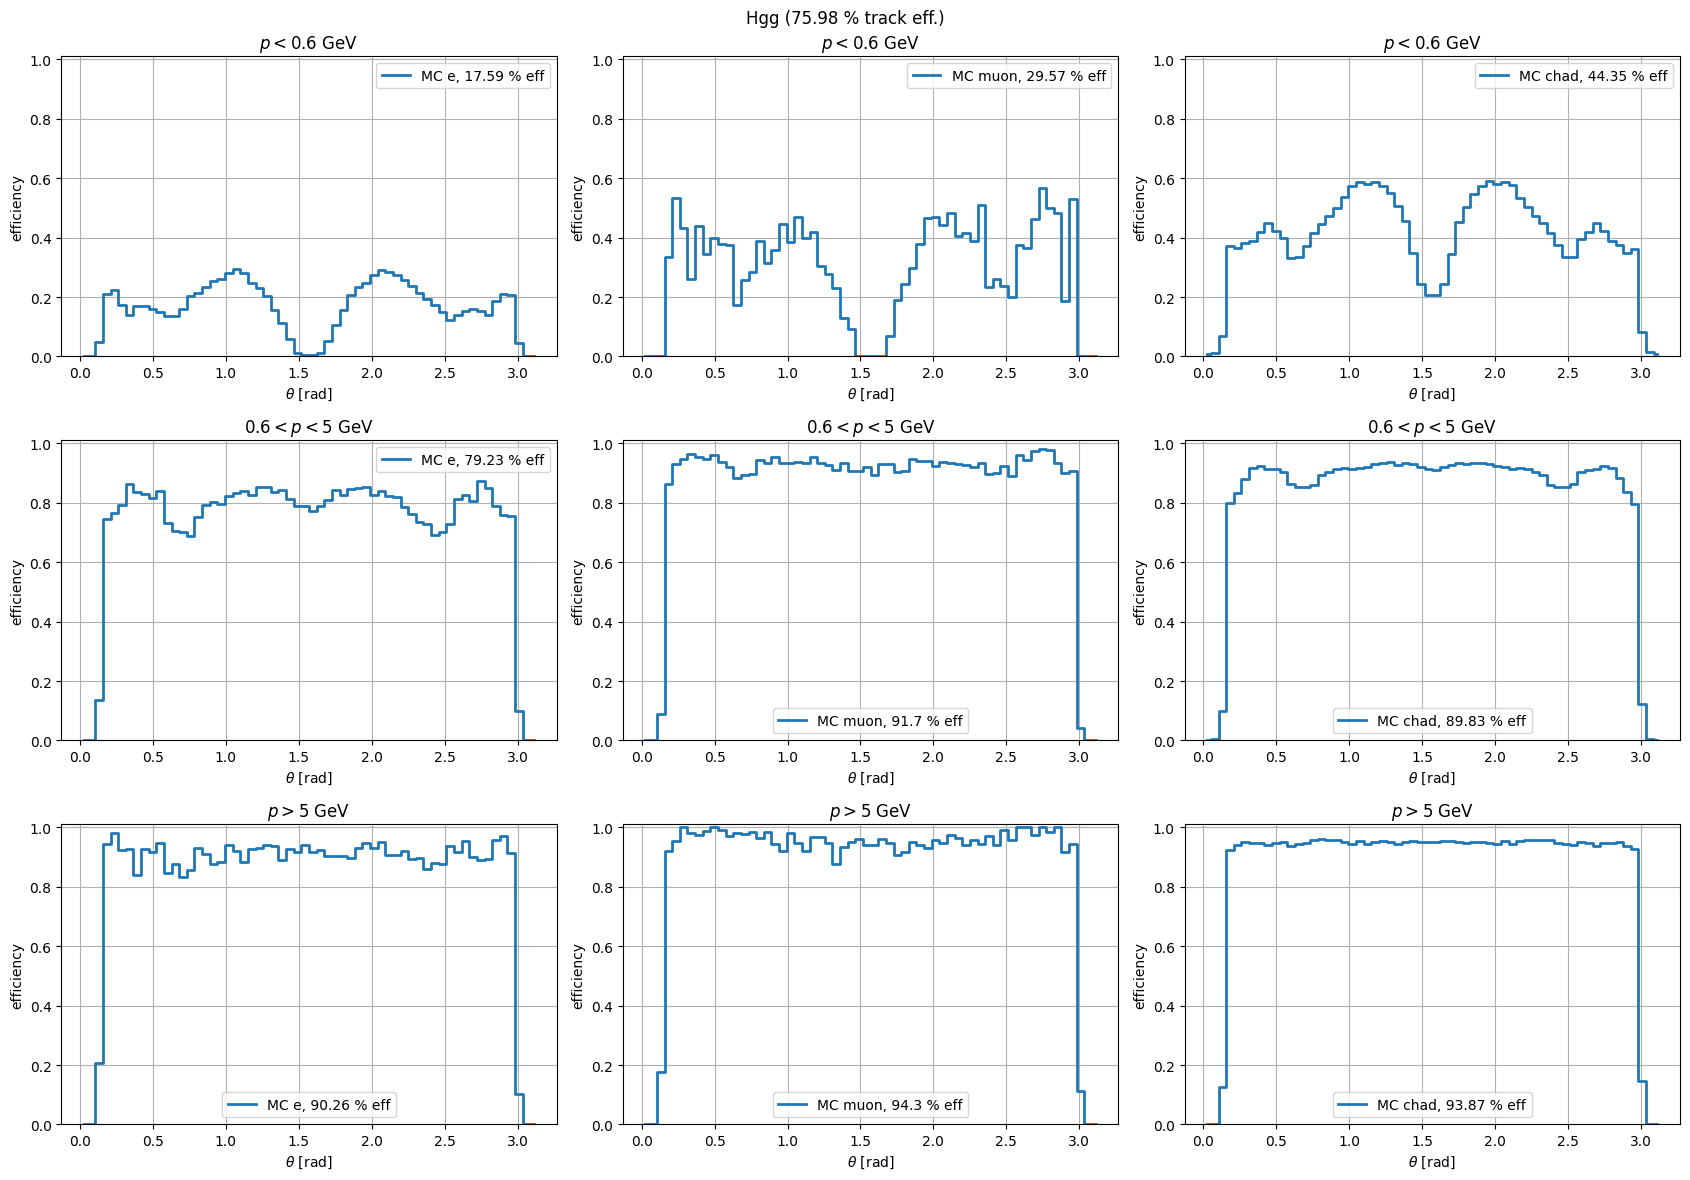

In [16]:
plot_pfo_alltype_sliced_p("gg", save=save_status)

/tmp/ipykernel_2554753/1752035420.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


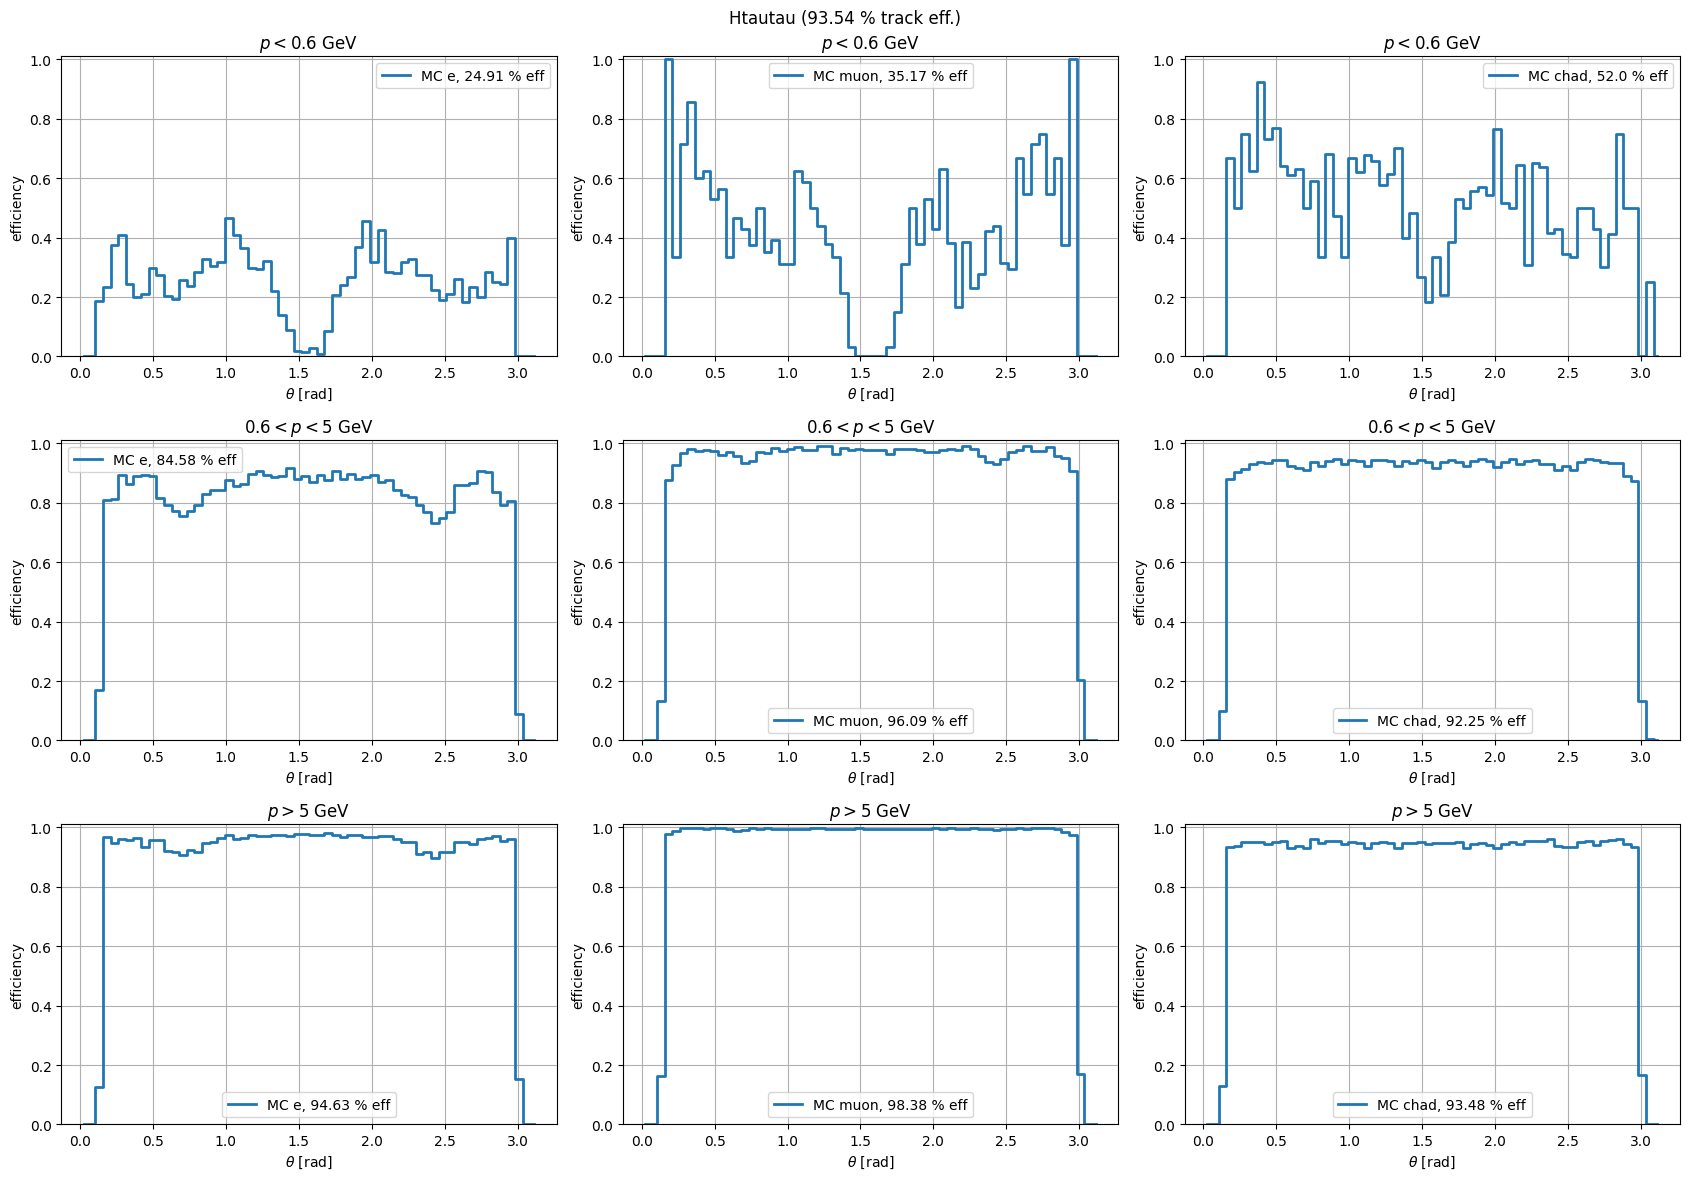

In [17]:
plot_pfo_alltype_sliced_p("tautau", save=save_status)

Now slices in theta! 

In [22]:
def ind_theta_cut(Htype, theta_cut):
    costheta_cut = 0.7
    if theta_cut=="barrel":
        ind_theta = np.where(np.abs(np.cos(np.concatenate(dic[Htype]["theta"]))) < costheta_cut)
    elif theta_cut=="endcap":
        ind_theta = np.where(np.abs(np.cos(np.concatenate(dic[Htype]["theta"]))) > costheta_cut)
    return ind_theta

def ind_x_pfo_theta(Htype, x, theta_cut):
    ind_x = ind_x_type(Htype, x)
    ind_theta = ind_theta_cut(Htype, theta_cut)

    ind_track_found = np.where(np.concatenate(dic[Htype]["mc_track_found"]) == 1)
    ind_x_thetacut_track = reduce(np.intersect1d, (ind_track_found, ind_x, ind_theta))

    return ind_x_thetacut_track

def subplot_pfo_thetacut(ax, Htype):
    num_bins = 60
    # Logarithmic binning for "momentum"
    ranges = [0, 50]
    bins = np.logspace(np.log10(ranges[0]+1e-1), np.log10(ranges[1]), num_bins)
    theta_cut_labels = [r"$|\cos\theta|<0.7$ (barrel)", r"$|\cos\theta|>0.7$ (endcap)"]
    obs = "momentum"
    for j, xtype in enumerate(["e", "muon", "chad"]):
        if Htype=="gg" and (xtype=="e" or xtype=="muon"):
            ranges = [0, 15]
        for i, theta_cut in enumerate(["barrel", "endcap"]):
            ind_xtype = ind_x_type(Htype, xtype)
            ind_theta = ind_theta_cut(Htype, theta_cut)
            ind_ref = reduce(np.intersect1d, (ind_xtype, ind_theta))

            ref_counts, bin_edges = np.histogram(np.concatenate(dic[Htype][obs])[ind_ref], bins=bins, range=ranges, density=False)

            ind_interest = ind_x_pfo_theta(Htype, xtype, theta_cut)

            # Normalize each histogram data
            track_ptype_data = np.concatenate(dic[Htype][obs])[ind_interest]
            normalized_track = normalize_hist(track_ptype_data, ref_counts, bins, range=ranges)

            # Plot normalized histograms
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting
            effi = eff(Htype, ind_ref)
            ax[i, j].plot(bin_centers, normalized_track, drawstyle='steps-mid', linewidth=2.0, label=f"MC {xtype}, {effi} % eff") #, label=f"MC {l}, track ({effi[2]}%)")
            ax[i, j].grid()
            ax[i, j].legend()
            ax[i, j].set_xlabel(r"$p$ [GeV]")
            ax[i, j].set_ylabel("efficiency")
            ax[i, j].set_ylim(0, 1.01)
            ax[i, j].set_title(theta_cut_labels[i])
            ax[i, j].set_xscale("log")


def plot_pfo_alltype_sliced_theta(Htype="bb", save=False):
    """plot theta but for 3 different p cuts"""
    fig, ax = plt.subplots(2,3, figsize=(17,8))
    ind_track_found = np.where(np.concatenate(dic[Htype]["mc_track_found"]) == 1)
    total_eff = np.round(len(ind_track_found[0])/len(np.concatenate(dic[Htype]["mc_track_found"]))*100, 2)
    fig.suptitle(f"H{Htype} ({total_eff} % track eff.)")
    subplot_pfo_thetacut(ax, Htype=Htype)

    plt.tight_layout()
    if save:
        plt.savefig(f"./hist-trackPFOcheck-trackeff/H{Htype}_trackeff_sliced_theta.pdf")
    plt.show()

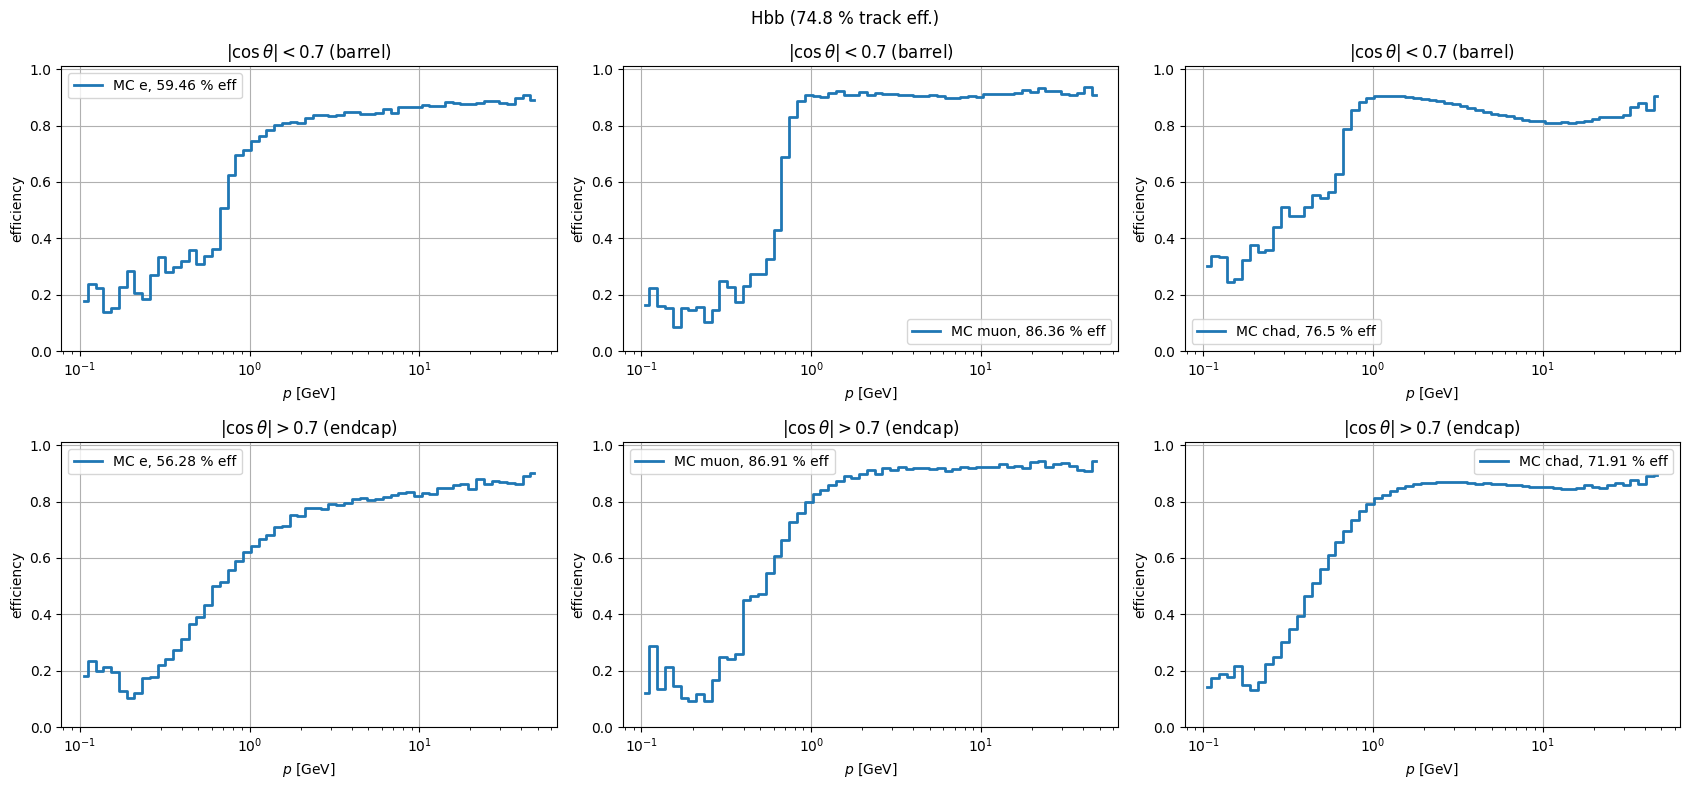

In [23]:
plot_pfo_alltype_sliced_theta(save=save_status)

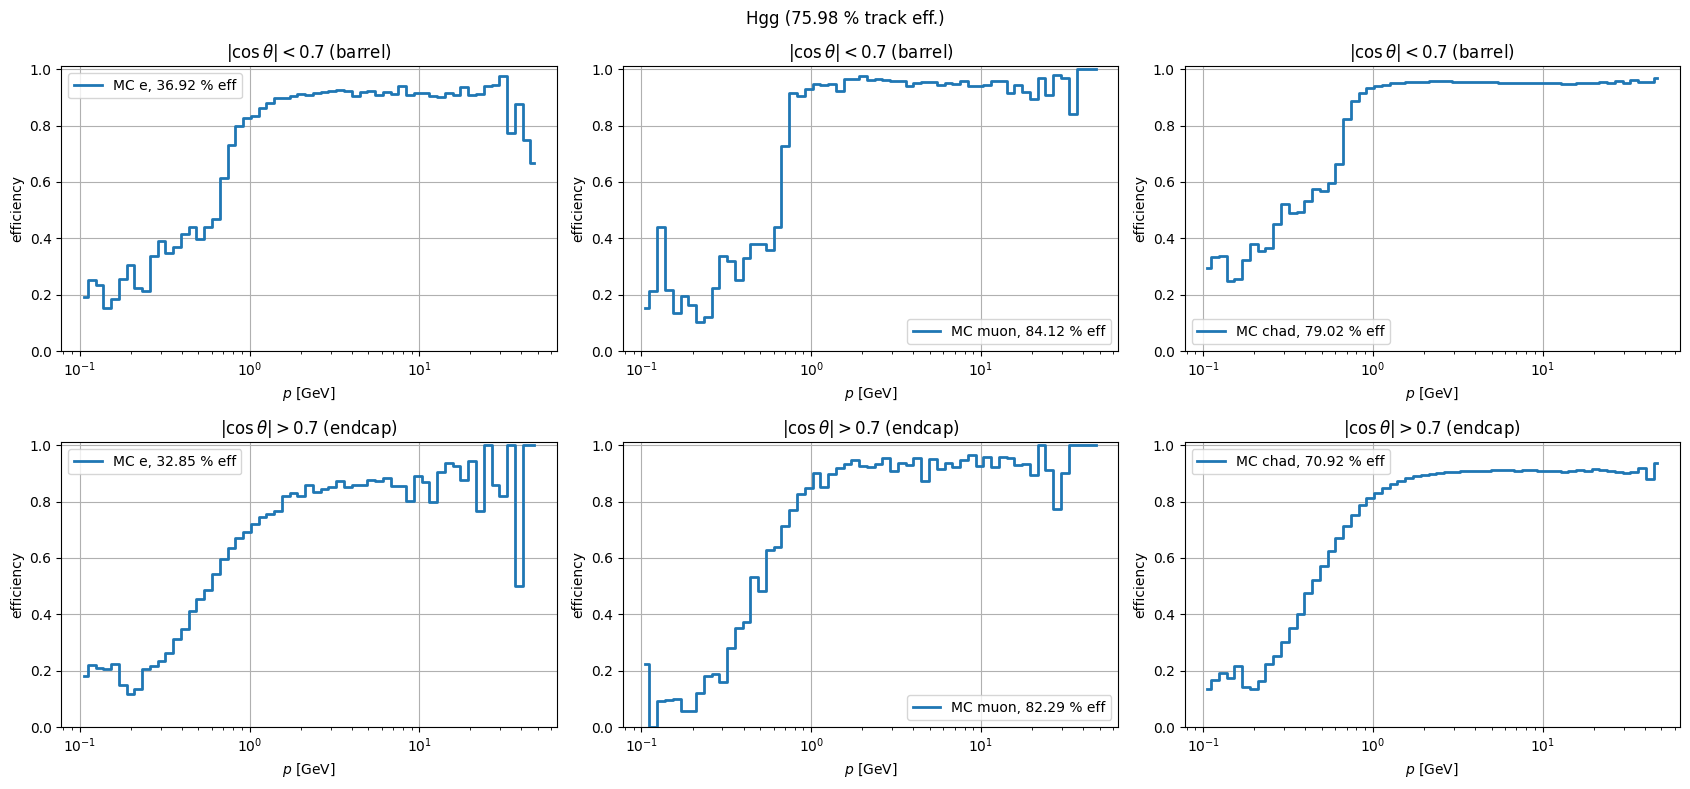

In [24]:
plot_pfo_alltype_sliced_theta("gg", save=save_status)

/tmp/ipykernel_2554753/1752035420.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


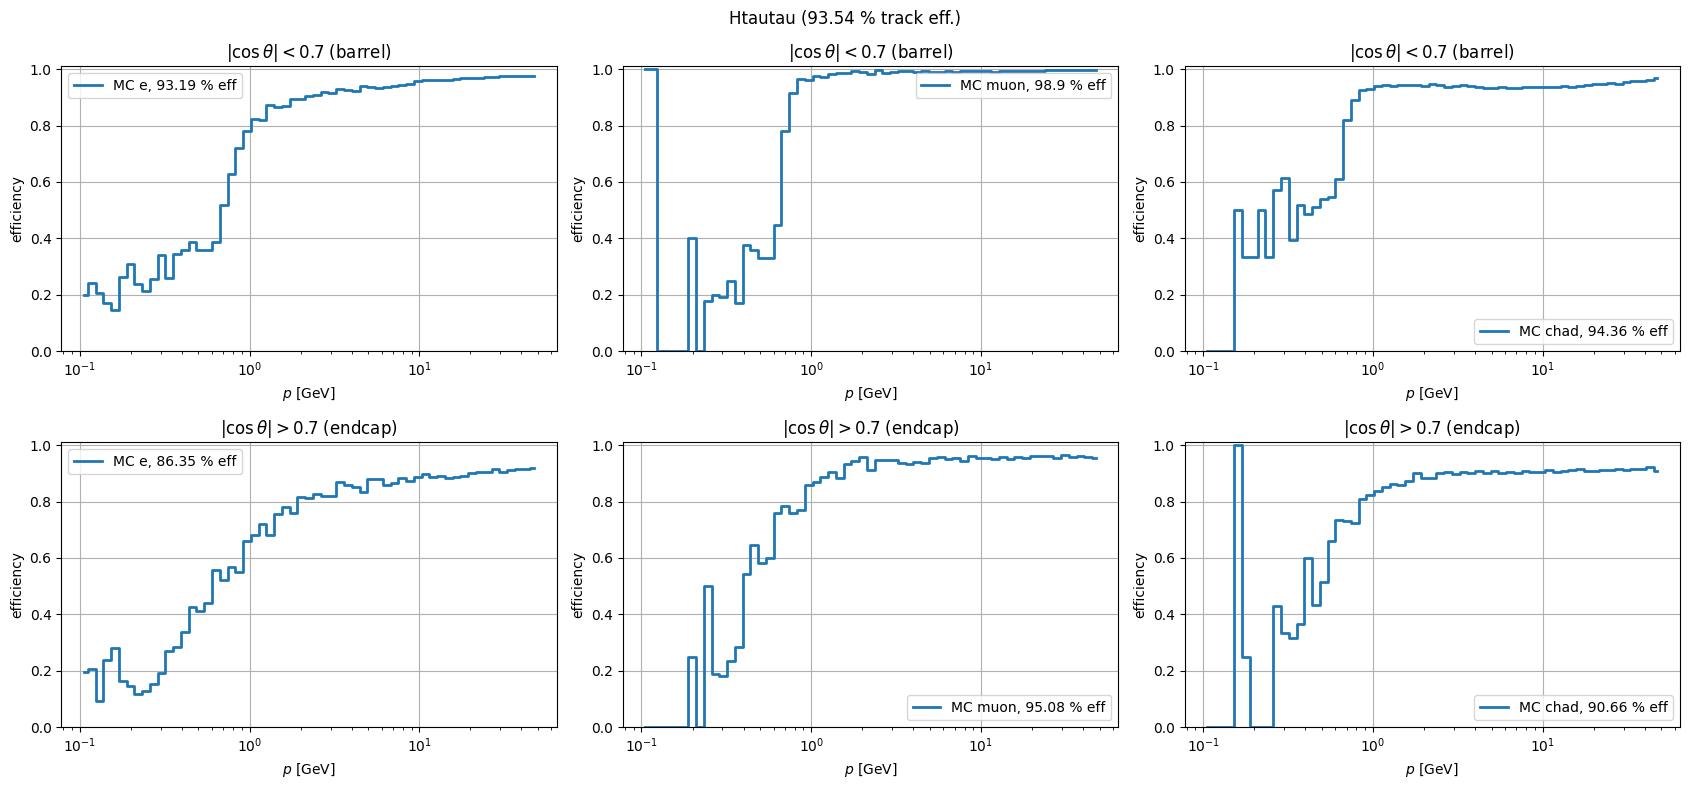

In [25]:
plot_pfo_alltype_sliced_theta("tautau", save=save_status)